<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/project_phase_2/Project/Phase2/Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MoneyBall Model

##Split Data into Training and Validation

In [1]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-10-11 01:40:38--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-10-11 01:40:39--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-10-11 01:40:39--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response..

In [2]:
import pandas as pd

data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


Split the Data According to Years

In [3]:
##Get the Features of interest
features = ['OBP', 'SLG', 'BA']
output = ['RS']

In [4]:
import numpy as np

years = data['Year'].unique()
val_years = np.random.choice( years, int(0.25 * len(years)), replace=False )
print(val_years)

[2005 2006 1976 1983 2001 1962 1996 1969 1967 1979 2008]


In [5]:
##Establish the Training Set and the Validation Sets

TRAIN = pd.DataFrame()
VALID = pd.DataFrame()

for y in years:
  elem = data[ data['Year'] == y][features + output]
  if y in val_years:
    VALID = pd.concat( [VALID, elem] )
  else:
    TRAIN = pd.concat( [TRAIN, elem] )

##Training Set
TRAIN = TRAIN.to_numpy()
XTRAIN = TRAIN[:, :-1]
YTRAIN = TRAIN[:, -1]

##Validation Set
VALID = VALID.to_numpy()
XVALID = VALID[:, :-1]
YVALID = VALID[:, -1]

In [6]:
##Adjust the Training Data
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Adjust the Validation Data
XVALID -= mean
XVALID /= std

##Compare Neural Network with Linear Regression

Define Utilities for Evaluation

In [7]:
import matplotlib.pyplot as plt
from sklearn import metrics

DEFAULT_EPOCHS = 256

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    f, ax = plt.subplots()
    ax.plot(history.history['loss'], '-', label = 'Training', color = 'blue')
    ax.plot(history.history['val_loss'], '--', label = 'Validation', color = 'orange')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.set_yscale('log')
    ax.legend()
    return (f, ax)

class RegEvalUtil:
  @staticmethod
  def get_eval_metrics(y_true, y_pred):
    return { 'mse': metrics.mean_squared_error(y_true, y_pred),
            'mae': metrics.mean_absolute_error(y_true, y_pred),
            'r2': metrics.r2_score(y_true, y_pred)}


Define the Neural Network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


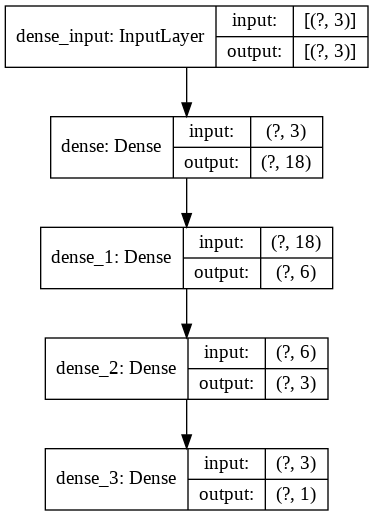

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn = Sequential()
runs_nn.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn.add( Dense(6, activation='relu'))
runs_nn.add( Dense(3, activation = 'relu' ))
runs_nn.add( Dense(1, activation = 'relu' ))

runs_nn.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn.summary()
plot_model(runs_nn, to_file='runs_nn.png', show_shapes=True)

In [9]:
##Train the Model
history_nn = runs_nn.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

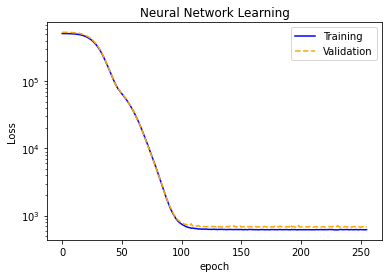

In [10]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn)
figs[1].set_title('Neural Network Learning')
plt.savefig('nn_learn_curve.png')
figs[0].show()

In [11]:
##Get the Predictions on Training and Validation
train_pred = runs_nn.predict(XTRAIN)
valid_pred = runs_nn.predict(XVALID)

nn_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

Define the Linear Regression Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


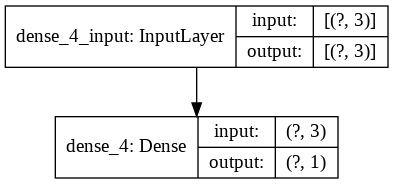

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

lin = Sequential()
lin.add( Dense(1, input_dim = len(features), activation = 'linear'))
lin.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
lin.summary()
plot_model(lin, to_file='lin.png', show_shapes=True)

In [13]:
##Train the Model
history_lin = lin.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

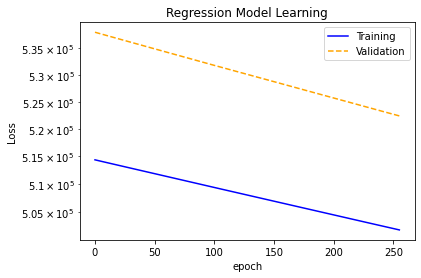

In [14]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_lin)
figs[1].set_title('Regression Model Learning')
plt.savefig('lin_learn_curve.png')
figs[0].show()

In [15]:
##Get the Predictions on Training and Validation
train_pred = lin.predict(XTRAIN)
valid_pred = lin.predict(XVALID)

lin_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

comp_nn_lin = pd.concat([nn_metrics, lin_metrics]).T
comp_nn_lin.to_csv('nn_vs_lin.csv')
comp_nn_lin.head()

,mse,mae,r2,mse,mae,r2
train,616.040326,19.895854,0.924663,501810.171581,703.696393,-60.367896
valid,683.513221,20.606355,0.922486,522392.779051,717.816683,-58.242085


##Performance if Incorrect Activation Function Used

Set Last Layer to Have Sigmoid

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 18)                72        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


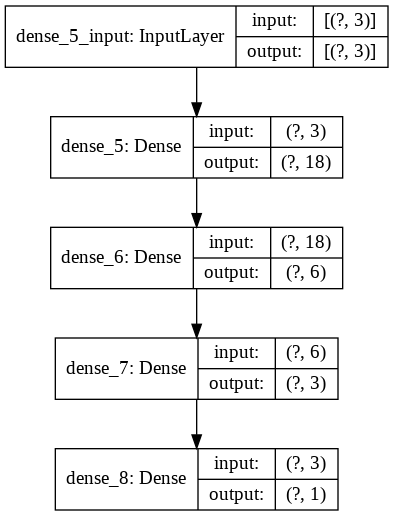

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_last_sig = Sequential()
runs_nn_last_sig.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn_last_sig.add( Dense(6, activation='relu'))
runs_nn_last_sig.add( Dense(3, activation = 'relu' ))
runs_nn_last_sig.add( Dense(1, activation = 'sigmoid' ))

runs_nn_last_sig.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_last_sig.summary()
plot_model(runs_nn_last_sig, to_file='runs_nn_last_sig.png', show_shapes=True)

In [17]:
##Train the Model
history_nn_last_sig = runs_nn_last_sig.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

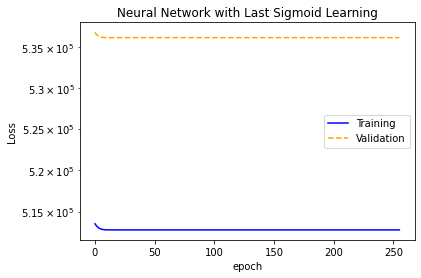

In [18]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_last_sig)
figs[1].set_title('Neural Network with Last Sigmoid Learning')
plt.savefig('last_sig_learn_curve.png')
figs[0].show()

In [19]:
##Compare the results of the incorrect vs the correct last activation
train_pred = runs_nn_last_sig.predict(XTRAIN)
valid_pred = runs_nn_last_sig.predict(XVALID)

last_sig_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

comp_nn_last_sig = pd.concat([nn_metrics, last_sig_metrics]).T
comp_nn_last_sig.to_csv('nn_vs_last_sig.csv')
comp_nn_last_sig.head()

,mse,mae,r2,mse,mae,r2
train,616.040326,19.895854,0.924663,512821.760593,710.383475,-61.714537
valid,683.513221,20.606355,0.922486,536191.434028,726.204861,-59.806925


Set All Layers to Sigmoid Activations

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 18)                72        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 114       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


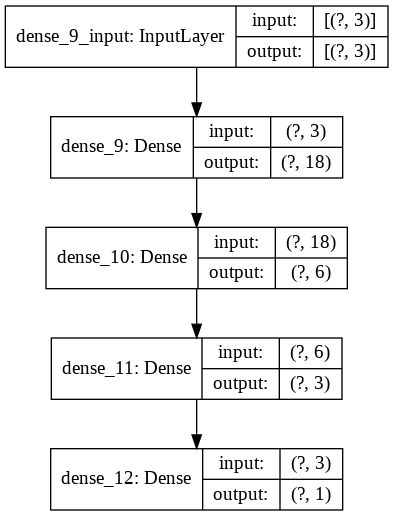

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_all_sig = Sequential()
runs_nn_all_sig.add( Dense(18, input_dim = len(features), activation = 'sigmoid'))
runs_nn_all_sig.add( Dense(6, activation='sigmoid'))
runs_nn_all_sig.add( Dense(3, activation = 'sigmoid' ))
runs_nn_all_sig.add( Dense(1, activation = 'sigmoid' ))

runs_nn_all_sig.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_all_sig.summary()
plot_model(runs_nn_all_sig, to_file='runs_nn_all_sig.png', show_shapes=True)

In [21]:
##Train the Model
history_nn_all_sig = runs_nn_all_sig.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

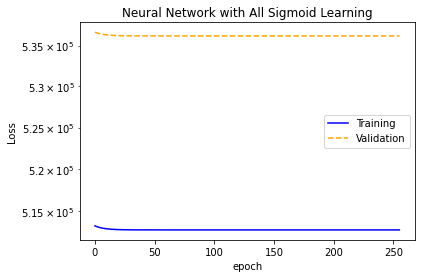

In [22]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_all_sig)
figs[1].set_title('Neural Network with All Sigmoid Learning')
plt.savefig('all_sig_learn_curve.png')
figs[0].show()

In [23]:
##Compare the results of the sigmoid on regression model
train_pred = runs_nn_all_sig.predict(XTRAIN)
valid_pred = runs_nn_all_sig.predict(XVALID)

all_sig_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

comp_nn_all_sig = pd.concat([nn_metrics, all_sig_metrics]).T
comp_nn_all_sig.to_csv('nn_vs_all_sig.csv')
comp_nn_all_sig.head()

,mse,mae,r2,mse,mae,r2
train,616.040326,19.895854,0.924663,512821.760593,710.383475,-61.714537
valid,683.513221,20.606355,0.922486,536191.434028,726.204861,-59.806925


##Overfitting Data

Define the Overfitting Network

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 7         
Total params: 3,153
Trainable params: 3,153
Non-trainable params: 0
____________________________________________________

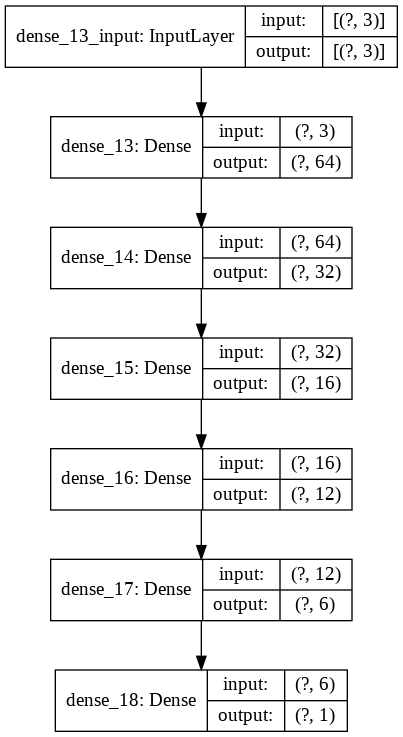

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

overfit = Sequential()
overfit.add( Dense(64, input_dim = len(features), activation = 'relu'))
overfit.add( Dense(32, activation = 'relu'))
overfit.add( Dense(16, activation= 'relu'))
overfit.add( Dense(12, activation = 'relu'))
overfit.add( Dense(6, activation = 'relu'))
overfit.add( Dense(1, activation = 'relu'))

overfit.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
overfit.summary()
plot_model(overfit, to_file='overfit.png', show_shapes=True)

In [25]:
##Train the Model
history_overfit = overfit.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = 8 * DEFAULT_EPOCHS,
                      verbose = 0)

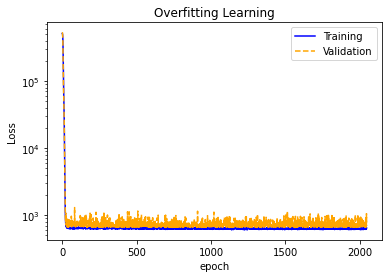

In [26]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_overfit)
figs[1].set_title('Overfitting Learning')
plt.savefig('overfit_learn_curve.png')
figs[0].show()

In [27]:
##Get the Predictions on Training and Validation
train_pred = overfit.predict(XTRAIN)
valid_pred = overfit.predict(XVALID)

overfit_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

overfit_metrics.head().T.to_csv('overfit.csv')
overfit_metrics.head().T.head()

,mse,mae,r2
train,620.225632,19.936592,0.924151
valid,698.320221,20.703677,0.920807


##Overfitting Data: Output Feature as Input

Set the Training And Validation Data to have the Output as an Input Feature

In [28]:
##Establish the Training Set and the Validation Sets

TRAIN_INPUT = pd.DataFrame()
VALID_INPUT = pd.DataFrame()

for y in years:
  elem = data[ data['Year'] == y][features + output]
  if y in val_years:
    VALID_INPUT = pd.concat( [VALID_INPUT, elem] )
  else:
    TRAIN_INPUT = pd.concat( [TRAIN_INPUT, elem] )

##Training Set
TRAIN_INPUT = TRAIN_INPUT.to_numpy()
##Include the output
XTRAIN_INPUT = TRAIN_INPUT[:, :]
##Create copy to prevent updates to true output
YTRAIN_INPUT = np.array(TRAIN_INPUT[:, -1])

##Validation Set
VALID_INPUT = VALID_INPUT.to_numpy()
##Include the output
XVALID_INPUT = VALID_INPUT[:, :]
##Create copy to prevent updates to true output
YVALID_INPUT = np.array(VALID_INPUT[:, -1])

In [29]:
##Adjust the Training Data
mean = XTRAIN_INPUT.mean(axis = 0)
XTRAIN_INPUT -= mean
std = XTRAIN_INPUT.std(axis = 0)
XTRAIN_INPUT /= std

##Adjust the Validation Data
XVALID_INPUT -= mean
XVALID_INPUT /= std

Define the Overfitting Model with Output as Feature

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 36)                180       
_________________________________________________________________
dense_20 (Dense)             (None, 18)                666       
_________________________________________________________________
dense_21 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 117       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 60        
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                

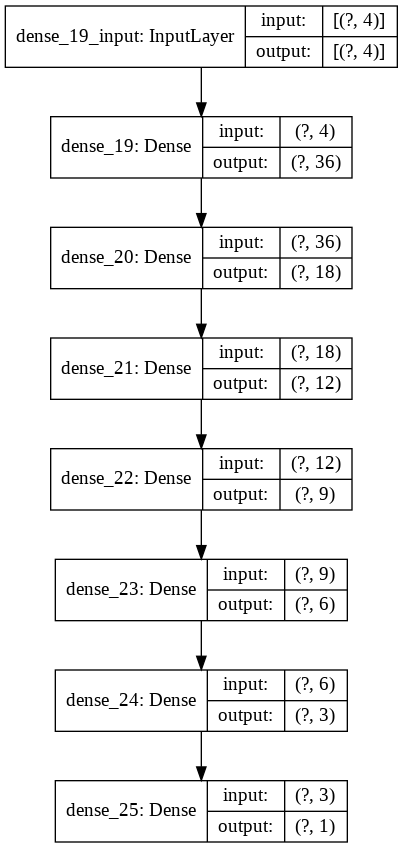

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

overfit_input = Sequential()
overfit_input.add( Dense(36, input_dim = len( XVALID_INPUT[0,:]), activation = 'relu'))
overfit_input.add( Dense(18, activation ='relu'))
overfit_input.add( Dense(12, activation = 'relu'))
overfit_input.add( Dense(9, activation = 'relu'))
overfit_input.add( Dense(6, activation = 'relu'))
overfit_input.add( Dense(3, activation = 'relu'))
overfit_input.add( Dense(1, activation = 'relu'))

overfit_input.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
overfit_input.summary()
plot_model(overfit_input, to_file='overfit_input.png', show_shapes=True)

In [31]:
##Train the Model
history_overfit_input = overfit_input.fit( XTRAIN_INPUT, YTRAIN_INPUT,
                      validation_data = (XVALID_INPUT, YVALID_INPUT),
                      epochs = 8 * DEFAULT_EPOCHS,
                      verbose = 0)

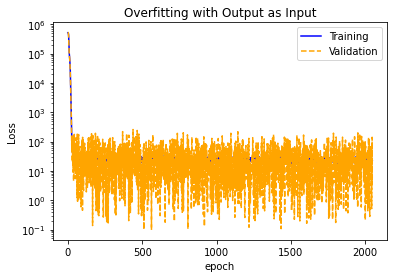

In [32]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_overfit_input)
figs[1].set_title('Overfitting with Output as Input')
plt.savefig('overfit_input_learn_curve.png')
figs[0].show()

In [33]:
##Get the Predictions on Training and Validation
train_pred = overfit_input.predict(XTRAIN_INPUT)
valid_pred = overfit_input.predict(XVALID_INPUT)

overfit_input_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

overfit_input_metrics.T.to_csv('overfit_input.csv')
overfit_input_metrics.T.head()

,mse,mae,r2
train,5.073854,2.094305,0.999380
valid,5.827625,2.248596,0.999339


##Download Information For Report

In [42]:
!res_dir=./resources

!if [[ -e $res_dir ]]; then rm -rf $res_dir; fi
!mkdir $res_dir

mkdir: missing operand
Try 'mkdir --help' for more information.


In [35]:
!mv *.csv $res_dir
!mv *.png $res_dir

mv: target 'overfit_input.csv' is not a directory
mv: target 'runs_nn.png' is not a directory


In [43]:
!tar -cvf phase2.tar $res_dir

./
./.config/
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/active_config
./.config/configurations/
./.config/configurations/config_default
./.config/.last_update_check.json
./.config/logs/
./.config/logs/2020.10.05/
./.config/logs/2020.10.05/16.30.24.482958.log
./.config/logs/2020.10.05/16.31.02.426408.log
./.config/logs/2020.10.05/16.31.18.233006.log
./.config/logs/2020.10.05/16.31.17.532147.log
./.config/logs/2020.10.05/16.30.42.685964.log
./.config/logs/2020.10.05/16.30.57.046091.log
./.config/gce
./.config/.last_survey_prompt.yaml
./.config/.metricsUUID
./nn_vs_all_sig.csv
./overfit_input_learn_curve.png
./runs_nn_all_sig.png
./nn_learn_curve.png
./lin_learn_curve.png
./overfit.csv
./overfit.png
./runs_nn.png
./nn_vs_lin.csv
./all_sig_learn_curve.png
./nn_vs_last_sig.csv
./lin.png
./overfit_input.png
./overfit_learn_curve.png
tar: ./phase2.tar: file is the archive; not dumped
./last_sig_learn_curve.png
./Baseball.csv
./runs_nn_last_sig.png
./overfit_input.

In [46]:
from google.colab import files
files.download('phase2.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>